In [1]:
%cd /content
!mkdir -p nmt_rnn/data nmt_rnn/models nmt_rnn/checkpoints
%cd nmt_rnn

/content
/content/nmt_rnn


In [3]:
pip install sentencepiece >/dev/null

In [4]:
!pip install torch torchtext sacrebleu


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 6.1 MB/s eta 0:00:00


In [5]:
%%writefile /content/nmt_rnn/data_loader.py
import os
import json
import re
import random
import sentencepiece as spm
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

# -------------------------
# Config defaults
# -------------------------
SP_MODEL_PREFIX = "/content/nmt_rnn/data/spm"
SUBWORD_VOCAB_SIZE = 8000

def _clean_text(text: str) -> str:
    if not isinstance(text, str):
        text = str(text)
    text = text.strip()
    # preserve letters, digits, punctuation and Unicode ranges (Kannada block included)
    text = re.sub(r"[^0-9A-Za-z\u0C80-\u0CFF\s\.,\!\?'\-]", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.lower().strip()

def load_merged_json(path: str, src_key="sourceText", tgt_key="targetText"):
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    src_sents, tgt_sents = [], []
    for d in data:
        if src_key in d and tgt_key in d:
            s = _clean_text(d[src_key])
            t = _clean_text(d[tgt_key])
            if s != "" and t != "":
                src_sents.append(s)
                tgt_sents.append(t)
    return src_sents, tgt_sents

def train_sentencepiece(src_sents, tgt_sents, prefix=SP_MODEL_PREFIX, vocab_size=SUBWORD_VOCAB_SIZE):
    os.makedirs(os.path.dirname(prefix), exist_ok=True)
    train_txt = prefix + "_train.txt"
    # Combine and write training file only once
    with open(train_txt, "w", encoding="utf-8") as f:
        for s in src_sents:
            f.write(s + "\n")
        for t in tgt_sents:
            f.write(t + "\n")
    spm.SentencePieceTrainer.Train(
        f"--input={train_txt} --model_prefix={prefix} --vocab_size={vocab_size} "
        f"--character_coverage=1.0 --model_type=bpe --pad_id=0 --unk_id=1 --bos_id=2 --eos_id=3"
    )
    sp = spm.SentencePieceProcessor()
    sp.load(prefix + ".model")
    return sp, prefix + ".model"

def _encode_with_sp(sp, sentence: str, max_len: int):
    ids = sp.encode(sentence, out_type=int)
    ids = [sp.bos_id()] + ids + [sp.eos_id()]
    if len(ids) > max_len:
        ids = ids[:max_len]
    ids += [sp.pad_id()] * (max_len - len(ids))
    return ids

def make_dataloaders(
    path,
    batch_size=32,
    val_split=0.1,
    vocab_size=SUBWORD_VOCAB_SIZE,
    max_len=None,
    downsample_single_word_ratio=0.35,
):
    """
    path: path to merged JSON (list of {"sourceText","targetText"})
    Returns: train_loader, val_loader, sp_processor, sp_model_path, max_len
    """
    # load
    src_sents, tgt_sents = load_merged_json(path)
    if len(src_sents) == 0:
        raise ValueError("No parallel sentence pairs found. Check JSON format and keys 'sourceText'/'targetText'.")

    # tag single-word pairs and sentence pairs
    pairs = list(zip(src_sents, tgt_sents))
    single_word_pairs = [p for p in pairs if (len(p[0].split()) == 1 and len(p[1].split()) == 1)]
    sentence_pairs = [p for p in pairs if not (len(p[0].split()) == 1 and len(p[1].split()) == 1)]

    # Downsample single-word pairs so they don't dominate
    max_single = int(len(sentence_pairs) * (downsample_single_word_ratio / (1 - downsample_single_word_ratio) + 0.0001))
    if max_single < 0:
        max_single = 0
    if len(single_word_pairs) > max_single:
        single_word_pairs = random.sample(single_word_pairs, max_single)

    merged = sentence_pairs + single_word_pairs
    random.shuffle(merged)
    src_sents = [s for s, t in merged]
    tgt_sents = [t for s, t in merged]

    # estimate max_len if not provided (95th percentile of token count in words)
    lens = [len(s.split()) for s in src_sents + tgt_sents]
    import numpy as np
    if max_len is None:
        max_len = int(np.percentile(lens, 95)) + 4  # +4 for bos/eos/pad margin

    # train SentencePiece once
    sp, sp_model_path = train_sentencepiece(src_sents, tgt_sents, prefix=SP_MODEL_PREFIX, vocab_size=vocab_size)

    # encode
    src_ids = [_encode_with_sp(sp, s, max_len) for s in src_sents]
    tgt_ids = [_encode_with_sp(sp, t, max_len) for t in tgt_sents]

    # tensors: convert to [seq_len, batch] format later in collate
    src_tensor = torch.tensor(src_ids, dtype=torch.long)
    tgt_tensor = torch.tensor(tgt_ids, dtype=torch.long)

    dataset = TensorDataset(src_tensor, tgt_tensor)
    val_size = int(len(dataset) * val_split)
    train_size = len(dataset) - val_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])

    def collate_fn(batch):
        src = torch.stack([b[0] for b in batch]).T  # [seq, batch]
        tgt = torch.stack([b[1] for b in batch]).T
        return src, tgt

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    return train_loader, val_loader, sp, sp_model_path, max_len

Writing /content/nmt_rnn/data_loader.py


In [6]:
%%writefile /content/nmt_rnn/models/seq2seq.py
import torch
import torch.nn as nn
import random

# ----------------------
# Bahdanau Attention
# ----------------------
class BahdanauAttention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        self.W_enc = nn.Linear(enc_hid_dim * 2, dec_hid_dim, bias=False)
        self.W_dec = nn.Linear(dec_hid_dim, dec_hid_dim, bias=False)
        self.v = nn.Linear(dec_hid_dim, 1, bias=False)

    def forward(self, dec_hidden, enc_outputs):
        # dec_hidden: [batch, dec_hid]
        # enc_outputs: [src_len, batch, enc_hid*2]
        enc_proj = self.W_enc(enc_outputs.permute(1, 0, 2))   # [batch, src_len, dec_hid]
        dec_proj = self.W_dec(dec_hidden).unsqueeze(1)        # [batch,1,dec_hid]
        energy = torch.tanh(enc_proj + dec_proj)              # [batch, src_len, dec_hid]
        scores = self.v(energy).squeeze(2)                    # [batch, src_len]
        attn = torch.softmax(scores, dim=1)                   # [batch, src_len]
        return attn

# ----------------------
# Encoder (bidirectional GRU)
# ----------------------
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=0)
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional=True)
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        # src: [src_len, batch]
        emb = self.dropout(self.embedding(src))               # [src_len, batch, emb_dim]
        outputs, hidden = self.rnn(emb)                       # outputs: [src_len, batch, enc_hid*2]
        # hidden: [num_layers*2, batch, enc_hid] -> combine last forward & backward
        hidden_cat = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)  # [batch, enc_hid*2]
        dec_init = torch.tanh(self.fc(hidden_cat))            # [batch, dec_hid]
        return outputs, dec_init

# ----------------------
# Decoder (GRU + attention)
# ----------------------
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, attention, dropout=0.3):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim, padding_idx=0)
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_tok, hidden, enc_outputs):
        # input_tok: [batch] (token ids)
        input_tok = input_tok.unsqueeze(0)                    # [1, batch]
        emb = self.dropout(self.embedding(input_tok))         # [1, batch, emb_dim]
        attn_weights = self.attention(hidden, enc_outputs)    # [batch, src_len]
        a = attn_weights.unsqueeze(1)                         # [batch,1,src_len]
        enc_out = enc_outputs.permute(1,0,2)                  # [batch, src_len, enc_hid*2]
        context = torch.bmm(a, enc_out)                       # [batch,1,enc_hid*2]
        context = context.permute(1,0,2)                      # [1,batch,enc_hid*2]
        rnn_input = torch.cat((emb, context), dim=2)          # [1,batch, emb+enc_hid*2]
        output, new_hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        output = output.squeeze(0)                            # [batch, dec_hid]
        new_hidden = new_hidden.squeeze(0)                    # [batch, dec_hid]
        emb_s = emb.squeeze(0)                                # [batch, emb_dim]
        context_s = context.squeeze(0)                        # [batch, enc_hid*2]
        pred = self.fc_out(torch.cat((output, context_s, emb_s), dim=1))  # [batch, output_dim]
        return pred, new_hidden

# ----------------------
# Seq2Seq (wrapper)
# ----------------------
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        # src: [src_len, batch]
        # trg: [trg_len, batch]
        trg_len, batch_size = trg.shape
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        enc_outputs, hidden = self.encoder(src)
        input_tok = trg[0, :]  # <bos>
        for t in range(1, trg_len):
            out, hidden = self.decoder(input_tok, hidden, enc_outputs)
            outputs[t] = out
            pred_token = out.argmax(1)
            input_tok = trg[t] if random.random() < teacher_forcing_ratio else pred_token
        return outputs


Writing /content/nmt_rnn/models/seq2seq.py


In [7]:
%%writefile /content/nmt_rnn/train.py
import os
import json
import time
import torch
import torch.nn as nn
import torch.optim as optim

from data_loader import make_dataloaders
from models.seq2seq import BahdanauAttention, Encoder, Decoder, Seq2Seq

# -----------------------
# Config - tweakable
# -----------------------
DATA_PATH = "/content/nmt_rnn/data/data.json"
CKPT_DIR = "/content/nmt_rnn/checkpoints"
os.makedirs(CKPT_DIR, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EMB_DIM = 256
ENC_H = 256
DEC_H = 512
BATCH = 32
LR = 3e-4
EPOCHS = 25
FINE_EPOCHS = 8
FINE_LR = 1e-4
CLIP = 1.0
TF_START = 1.0
TF_END = 0.2

# -----------------------
# Build data + model
# -----------------------
print("Preparing data...")
train_loader, val_loader, sp, sp_model_path, max_len = make_dataloaders(
    DATA_PATH, batch_size=BATCH, vocab_size=8000, max_len=None
)
VOCAB = sp.get_piece_size()
print(f"Vocab size (SentencePiece): {VOCAB}  max_len:{max_len}")

attn = BahdanauAttention(ENC_H, DEC_H)
enc = Encoder(VOCAB, EMB_DIM, ENC_H, DEC_H)
dec = Decoder(VOCAB, EMB_DIM, ENC_H, DEC_H, attn)
model = Seq2Seq(enc, dec, DEVICE).to(DEVICE)

opt = optim.Adam(model.parameters(), lr=LR)
crit = nn.CrossEntropyLoss(ignore_index=0)

# save losses
losses = {"train": [], "val": []}

best_val = float("inf")
print("🚀 Starting training...")

def teacher_forcing_ratio(epoch, total_epochs):
    # linear schedule from TF_START -> TF_END across training epochs
    return TF_END + (TF_START - TF_END) * (1 - (epoch - 1) / max(1, total_epochs - 1))

for epoch in range(1, EPOCHS + 1):
    model.train()
    epoch_loss = 0.0
    tf = teacher_forcing_ratio(epoch, EPOCHS)
    t0 = time.time()
    for src, tgt in train_loader:
        src, tgt = src.to(DEVICE), tgt.to(DEVICE)
        opt.zero_grad()
        out = model(src, tgt, teacher_forcing_ratio=tf)
        loss = crit(out[1:].reshape(-1, VOCAB), tgt[1:].reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP)
        opt.step()
        epoch_loss += loss.item()
    avg_train = epoch_loss / len(train_loader)

    # validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for src, tgt in val_loader:
            src, tgt = src.to(DEVICE), tgt.to(DEVICE)
            out = model(src, tgt, teacher_forcing_ratio=0.0)
            loss = crit(out[1:].reshape(-1, VOCAB), tgt[1:].reshape(-1))
            val_loss += loss.item()
    avg_val = val_loss / len(val_loader)

    losses["train"].append(avg_train)
    losses["val"].append(avg_val)

    print(f"Epoch {epoch:02d} | Train {avg_train:.3f} | Val {avg_val:.3f} | TF {tf:.2f} | time {(time.time()-t0):.1f}s")

    # save best
    if avg_val < best_val:
        best_val = avg_val
        ckpt = {"model_state": model.state_dict(), "sp_model_path": sp_model_path}
        torch.save(ckpt, os.path.join(CKPT_DIR, "best.pt"))
        # also dump losses
        with open(os.path.join(CKPT_DIR, "losses.json"), "w") as f:
            json.dump(losses, f)
        print("  ✔ Saved checkpoint")

# Fine-tune (lower LR)
print("\n🎯 Fine-tuning with lower LR...")
opt = optim.Adam(model.parameters(), lr=FINE_LR)
best_val_ft = float("inf")
for epoch in range(1, FINE_EPOCHS + 1):
    model.train()
    epoch_loss = 0.0
    tf = teacher_forcing_ratio(epoch, FINE_EPOCHS) * 0.6 + 0.2  # slightly lower TF during FT
    for src, tgt in train_loader:
        src, tgt = src.to(DEVICE), tgt.to(DEVICE)
        opt.zero_grad()
        out = model(src, tgt, teacher_forcing_ratio=tf)
        loss = crit(out[1:].reshape(-1, VOCAB), tgt[1:].reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP)
        opt.step()
        epoch_loss += loss.item()
    avg_train = epoch_loss / len(train_loader)

    # validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for src, tgt in val_loader:
            src, tgt = src.to(DEVICE), tgt.to(DEVICE)
            out = model(src, tgt, teacher_forcing_ratio=0.0)
            loss = crit(out[1:].reshape(-1, VOCAB), tgt[1:].reshape(-1))
            val_loss += loss.item()
    avg_val = val_loss / len(val_loader)

    losses["train"].append(avg_train)
    losses["val"].append(avg_val)
    print(f"[FT] Epoch {epoch:02d} | Train {avg_train:.3f} | Val {avg_val:.3f} | TF {tf:.2f}")

    if avg_val < best_val_ft:
        best_val_ft = avg_val
        ckpt = {"model_state": model.state_dict(), "sp_model_path": sp_model_path}
        torch.save(ckpt, os.path.join(CKPT_DIR, "best_finetuned.pt"))
        with open(os.path.join(CKPT_DIR, "losses.json"), "w") as f:
            json.dump(losses, f)
        print("  ✔ Saved fine-tuned checkpoint")

print("\nTraining finished. Checkpoints saved to", CKPT_DIR)


Writing /content/nmt_rnn/train.py


In [8]:
%%writefile /content/nmt_rnn/infer.py
import os
import torch
import torch.nn.functional as F
import sentencepiece as spm
from models.seq2seq import BahdanauAttention, Encoder, Decoder, Seq2Seq

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CKPT_DIR = "/content/nmt_rnn/checkpoints"
BEST = os.path.join(CKPT_DIR, "best_finetuned.pt")
FALLBACK = os.path.join(CKPT_DIR, "best.pt")
SP_PATH = None

# choose checkpoint
if os.path.exists(BEST):
    ckpt_path = BEST
elif os.path.exists(FALLBACK):
    ckpt_path = FALLBACK
else:
    raise FileNotFoundError("No checkpoint found. Run train.py first.")

ck = torch.load(ckpt_path, map_location=DEVICE)
sp_model_path = ck.get("sp_model_path")
if sp_model_path is None:
    raise RuntimeError("Checkpoint has no 'sp_model_path'. Re-train to produce consistent checkpoint.")

# load sentencepiece
sp = spm.SentencePieceProcessor()
sp.load(sp_model_path)
VOCAB = sp.get_piece_size()

# build model architecture (must match train)
EMB_DIM = 256
ENC_H = 256
DEC_H = 512

attn = BahdanauAttention(ENC_H, DEC_H)
enc = Encoder(VOCAB, EMB_DIM, ENC_H, DEC_H)
dec = Decoder(VOCAB, EMB_DIM, ENC_H, DEC_H, attn)
model = Seq2Seq(enc, dec, DEVICE).to(DEVICE)

model.load_state_dict(ck["model_state"])
model.eval()
print("✔ Model loaded successfully!")
print("\n🌐 English → Kannada Translator Ready (beam search). Type 'quit' to exit.\n")

# simple beam search
def beam_search(src_sentence, beam_size=3, max_len=60):
    model.eval()
    tokens = [sp.bos_id()] + sp.encode(src_sentence.lower(), out_type=int) + [sp.eos_id()]
    src = torch.LongTensor(tokens).unsqueeze(1).to(DEVICE)  # [seq, 1]
    with torch.no_grad():
        enc_out, hidden = model.encoder(src)
    # beams: list of tuples (token_list, score, hidden_state)
    beams = [([sp.bos_id()], 0.0, hidden)]
    completed = []
    for _ in range(max_len):
        new_beams = []
        for seq, score, hid in beams:
            last = seq[-1]
            if last == sp.eos_id():
                completed.append((seq, score))
                continue
            inp = torch.LongTensor([last]).to(DEVICE)
            with torch.no_grad():
                out, new_h = model.decoder(inp, hid, enc_out)
                logp = F.log_softmax(out, dim=1)  # [batch=1, vocab]
                topk = torch.topk(logp, beam_size, dim=1)
                for k in range(beam_size):
                    tok = int(topk.indices[0, k].item())
                    sc = float(topk.values[0, k].item())
                    new_seq = seq + [tok]
                    new_beams.append((new_seq, score + sc, new_h.clone()))
        # prune
        beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_size]
        if len(beams) == 0:
            break
    best = None
    if completed:
        best = max(completed, key=lambda x: x[1])[0]
    elif beams:
        best = beams[0][0]
    else:
        return ""
    # remove BOS/EOS and decode pieces
    pieces = [p for p in best if p not in (sp.bos_id(), sp.eos_id(), sp.pad_id())]
    return sp.decode(pieces)

# interactive
while True:
    txt = input("Enter English sentence: ").strip()
    if txt.lower() in ("quit", "exit"):
        break
    out = beam_search(txt, beam_size=4, max_len=80)
    print("Kannada:", out)
    print("-"*60)


Writing /content/nmt_rnn/infer.py


In [9]:
!python /content/nmt_rnn/train.py

Preparing data...
sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=/content/nmt_rnn/data/spm_train.txt --model_prefix=/content/nmt_rnn/data/spm --vocab_size=8000 --character_coverage=1.0 --model_type=bpe --pad_id=0 --unk_id=1 --bos_id=2 --eos_id=3
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: /content/nmt_rnn/data/spm_train.txt
  input_format: 
  model_prefix: /content/nmt_rnn/data/spm
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece

In [11]:
!python /content/nmt_rnn/infer.py

✔ Model loaded successfully!

🌐 English → Kannada Translator Ready (beam search). Type 'quit' to exit.

Enter English sentence: It is my turn
Kannada: ಇದು ನನ್ನ ಸರದಿ
------------------------------------------------------------
Enter English sentence: Is everything okay?
Kannada: ಎಲ್ಲವೂ ಸರಿಯಾಗಿದೆಯೇ?
------------------------------------------------------------
Enter English sentence: Close the windows
Kannada: ಕಿಟಕಿಗಳನ್ನು ಮುಚ್ಚಿ
------------------------------------------------------------
Enter English sentence: I lost my keys
Kannada: ನಾನು ನನ್ನ ಕೀಲಿಗಳನ್ನು ಹುಡುಕುತ್ತಿದ್ದೇನೆ
------------------------------------------------------------
Enter English sentence: friend
Kannada: ಸ್ನೇಹಿತ
------------------------------------------------------------
Enter English sentence: Traceback (most recent call last):
  File "/content/nmt_rnn/infer.py", line 90, in <module>
    txt = input("Enter English sentence: ").strip()
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt
^C


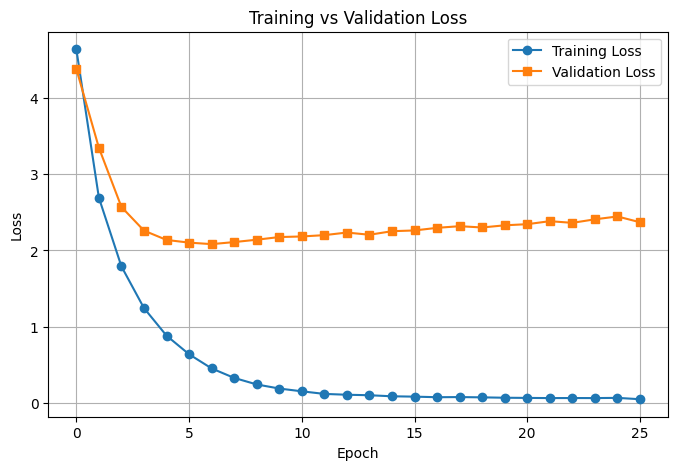

In [ ]:
import json
import matplotlib.pyplot as plt

LOSS_FILE = "/content/nmt_rnn/checkpoints/losses.json"

# Load saved losses
with open(LOSS_FILE, "r") as f:
    losses = json.load(f)

train_loss = losses["train"]
val_loss = losses["val"]

# Plot
plt.figure(figsize=(8,5))
plt.plot(train_loss, label="Training Loss", marker='o')
plt.plot(val_loss, label="Validation Loss", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.grid(True)
plt.legend()
plt.show()
